# Miscellanea

New releases of some packages:

* [Iris 1.9.2](http://scitools.org.uk/iris/docs/v1.9.2/whatsnew/1.9.html#version-1-9-2)
* [xarray](http://xarray.pydata.org/en/stable/whats-new.html#v0-7-0-21-january-2016)

# Plotting function with changing argument

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
%matplotlib inline

In [29]:
x = np.linspace(0,1,100)

In [36]:
plt.xkcd()

In [34]:
def pltsin(f, a):
    plt.plot(x, a*np.sin(2*np.pi*x*f))
    plt.ylim(-10,10)

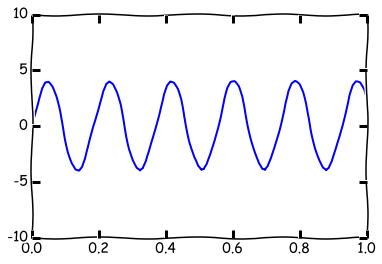

In [37]:
ipywidgets.interact(pltsin, f=(1,10,0.1), a=(1,10,1));

# ipywidgets

In [4]:
import ipywidgets

In [5]:
def f(a, b):
    return a+b

In [9]:
ipywidgets.interact(f, a=10, b=20)

30

<function __main__.f>

In [43]:
import iris
import cartopy.crs as ccrs

In [40]:
iris.FUTURE.netcdf_promote = True

In [45]:
fpath = '../data/data.nc'

In [82]:
def fun(filename, varname='', time=0, lev=0, cmap='viridis'):
    if varname == '':
        cube = iris.load(filename)[0]
    else:
        cube = iris.load(filename, varname)[0]
        
    arr = cube.data[time, lev, ...]
    
    fig, ax = plt.subplots()
    c = ax.contourf(arr, cmap=cmap)
    fig.colorbar(c, ax=ax)

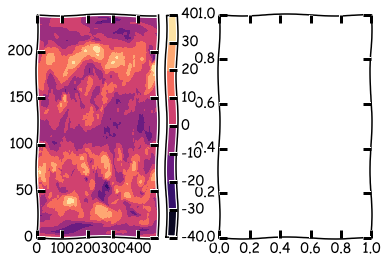

In [83]:
ipywidgets.interact(fun, filename=fpath, 
                    varname=['eastward_wind','northward_wind'], 
                    time=(0,2,1), lev=(0,3,1),
                    cmap=['viridis', 'inferno', 'magma', 'plasma'])